In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import networkx as nx
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
df_2017 = pd.read_csv('clean_BPI_2017.csv')
df_2012 = pd.read_csv('clean_BPI_2012.csv')

/var/folders/x_/q8m53n9s7qj76786p5830ldh0000gn/T/ipykernel_26290/923996830.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2017 = pd.read_csv('clean_BPI_2017.csv')


In [3]:
df_2012['concept:name'].value_counts()

concept:name
W_Completeren aanvraag            48240
W_Nabellen offertes               44543
W_Nabellen incomplete dossiers    23144
W_Valideren aanvraag              20148
W_Afhandelen leads                14882
A_SUBMITTED                       13065
A_PARTLYSUBMITTED                 13058
A_DECLINED                         7617
A_PREACCEPTED                      7349
O_SENT                             7011
O_CREATED                          7011
O_SELECTED                         7011
A_ACCEPTED                         5100
A_FINALIZED                        5000
O_CANCELLED                        3642
O_SENT_BACK                        3445
A_CANCELLED                        2796
A_REGISTERED                       2239
A_APPROVED                         2238
A_ACTIVATED                        2238
O_ACCEPTED                         2237
O_DECLINED                          802
W_Beoordelen fraude                 660
W_Wijzigen contractgegevens          11
Name: count, dtype: int64

In [4]:
df_2017['concept:name'].value_counts()

concept:name
W_Validate application        209285
W_Call after offers           190891
W_Call incomplete files       168363
W_Complete application        148756
W_Handle leads                 47227
O_Created                      42957
O_Create Offer                 42952
O_Sent (mail and online)       39665
A_Validating                   38779
A_Concept                      31486
A_Create Application           31481
A_Accepted                     31480
A_Complete                     31337
O_Returned                     23282
A_Incomplete                   23036
O_Cancelled                    20878
A_Submitted                    20397
O_Accepted                     17210
A_Pending                      17206
A_Cancelled                    10421
O_Refused                       4689
A_Denied                        3750
W_Assess potential fraud        3278
O_Sent (online only)            2024
W_Shortened completion           238
W_Personal Loan collection        22
Name: count, dtype: int64

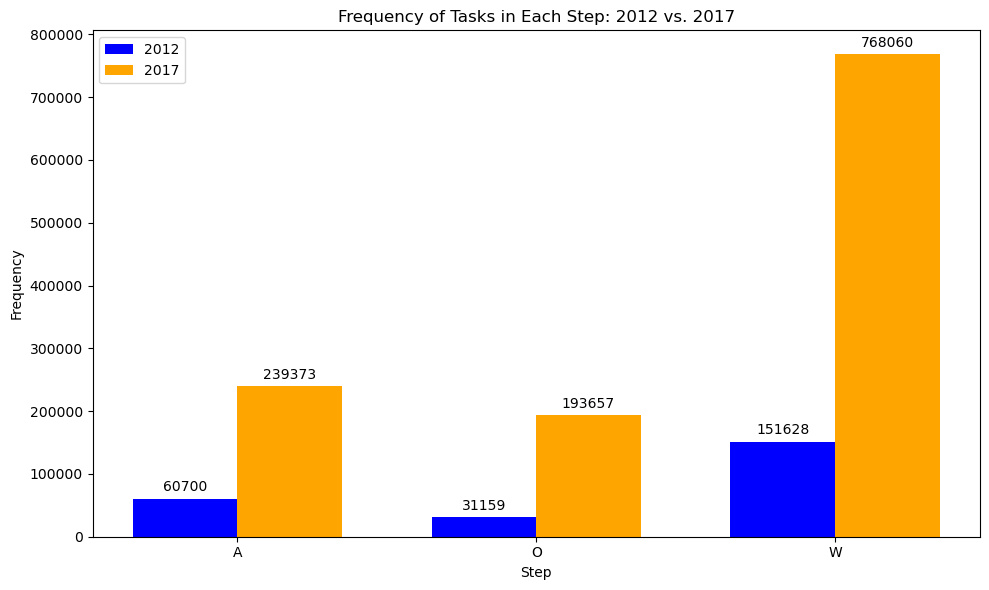

In [5]:
# Extract prefixes ('W_', 'O_', 'A_')
df_2012['prefix'] = df_2012['concept:name'].str.split('_').str[0]
df_2017['prefix'] = df_2017['concept:name'].str.split('_').str[0]

# Count the occurrences of each prefix for both years
df_2012_counts = df_2012['prefix'].value_counts().sort_index()
df_2017_counts = df_2017['prefix'].value_counts().sort_index()

# Ensure both Series have the same index order
df_2012_counts = df_2012_counts.reindex(index = df_2017_counts.index)

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(df_2012_counts))

# Plotting both years' data side by side
bars1 = ax.bar(index, df_2012_counts, bar_width, label='2012', color='blue')
bars2 = ax.bar(index + bar_width, df_2017_counts, bar_width, label='2017', color='orange')

# Adding the text on the bars for 2012 and 2017
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Finalizing the plot
ax.set_title('Frequency of Tasks in Each Step: 2012 vs. 2017')
ax.set_xlabel('Step')
ax.set_ylabel('Frequency')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_2012_counts.index)
ax.legend()

plt.tight_layout()
plt.show()


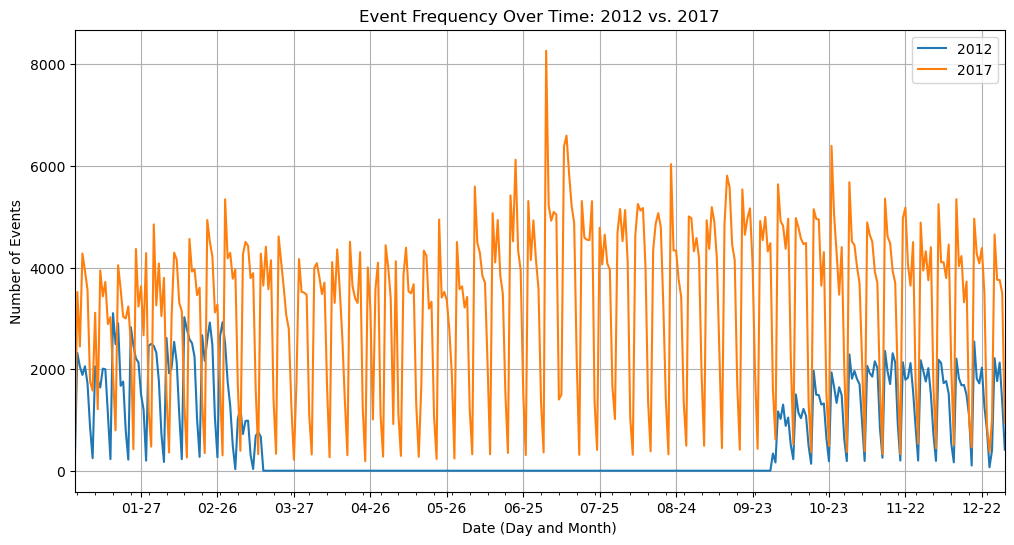

In [6]:
# Convert 'time:timestamp' to datetime
df_2012['time:timestamp'] = pd.to_datetime(df_2012['time:timestamp'])
df_2017['time:timestamp'] = pd.to_datetime(df_2017['time:timestamp'])

baseline_year = 2012
df_2012['adjusted_timestamp'] = df_2012['time:timestamp'].apply(lambda dt: dt.replace(year=baseline_year))
df_2017['adjusted_timestamp'] = df_2017['time:timestamp'].apply(lambda dt: dt.replace(year=baseline_year))

# Resample to get the count of events per day for both DataFrames
events_per_day_2012 = df_2012.set_index('adjusted_timestamp').resample('D').size()
events_per_day_2017 = df_2017.set_index('adjusted_timestamp').resample('D').size()

# Plotting both on the same figure for comparison
plt.figure(figsize=(12, 6))
events_per_day_2012.plot(kind='line', label='2012')
events_per_day_2017.plot(kind='line', label='2017')  

plt.title('Event Frequency Over Time: 2012 vs. 2017')
plt.xlabel('Date (Day and Month)')
plt.ylabel('Number of Events')
plt.legend()

# Set x-axis major formatter to display only day and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust interval as needed for clarity

plt.grid(True)
plt.show()

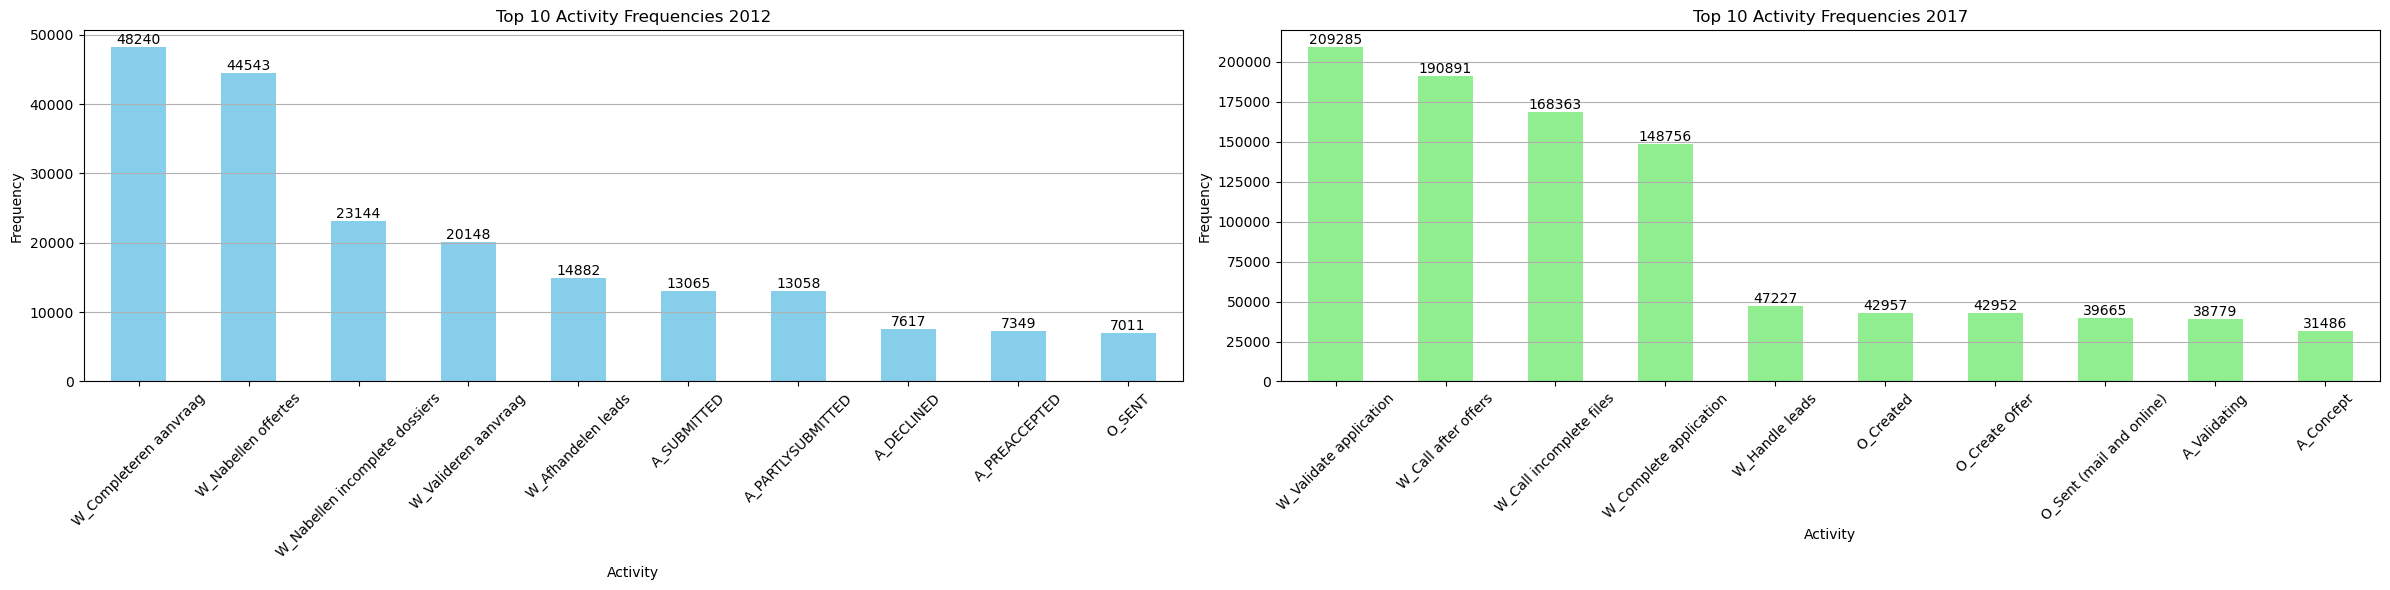

In [7]:
# Count the number of occurrences of each activity
activity_frequency_2012 = df_2012['concept:name'].value_counts().head(10)  # Top 10 activities for simplicity
activity_frequency_2017 = df_2017['concept:name'].value_counts().head(10)  # Top 10 activities for simplicity

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot for 2012
activity_frequency_2012.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Activity Frequencies 2012')
axes[0].set_xlabel('Activity')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

# Adding the text on the bars for 2012
for index, value in enumerate(activity_frequency_2012):
    axes[0].text(index, value, str(value), ha='center', va='bottom')

# Plot for 2017
activity_frequency_2017.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Activity Frequencies 2017')
axes[1].set_xlabel('Activity')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

# Adding the text on the bars for 2017
for index, value in enumerate(activity_frequency_2017):
    axes[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

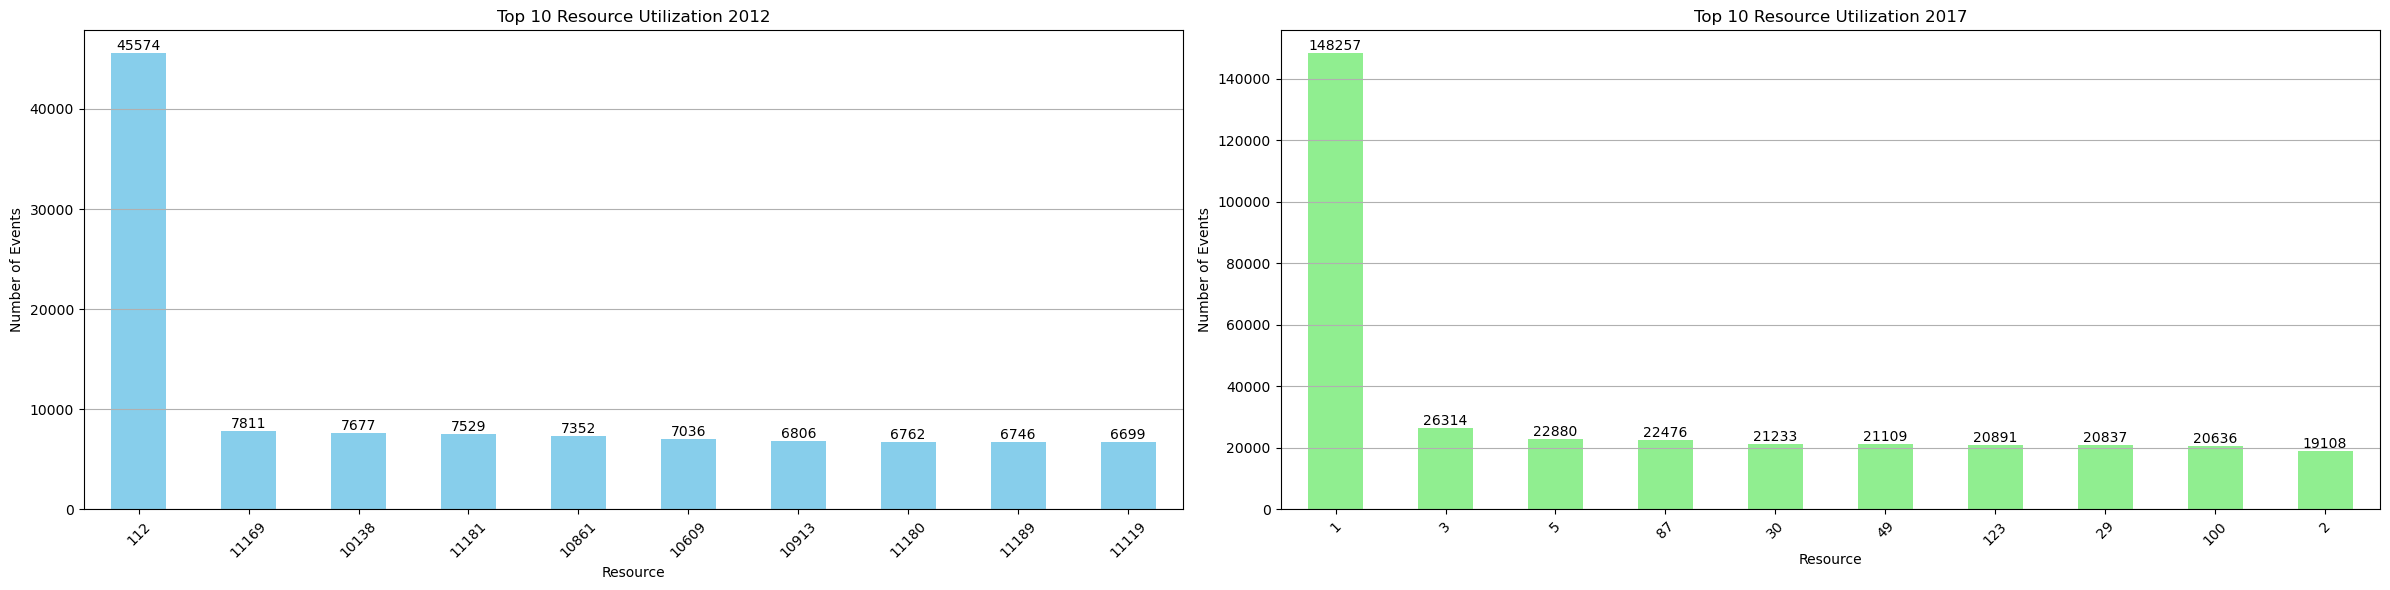

In [8]:
# Count the number of events per resource
resource_utilization_2012= df_2012['org:resource'].value_counts().head(10)  # Top 10 resources for simplicity
# Remove the 'User_' prefix from the 'org:resource' column
df_2017['org:resource'] = df_2017['org:resource'].str.replace('User_', '')
resource_utilization_2017 = df_2017['org:resource'].value_counts().head(10)  # Top 10 resources for simplicity

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

# Plot for 2012
resource_utilization_2012.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Resource Utilization 2012')
axes[0].set_xlabel('Resource')
axes[0].set_ylabel('Number of Events')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

# Adding the text on the bars for 2012
for index, value in enumerate(resource_utilization_2012):
    axes[0].text(index, value, str(value), ha='center', va='bottom')

# Plot for 2017
resource_utilization_2017.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Top 10 Resource Utilization 2017')
axes[1].set_xlabel('Resource')
axes[1].set_ylabel('Number of Events')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

# Adding the text on the bars for 2017
for index, value in enumerate(resource_utilization_2017):
    axes[1].text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

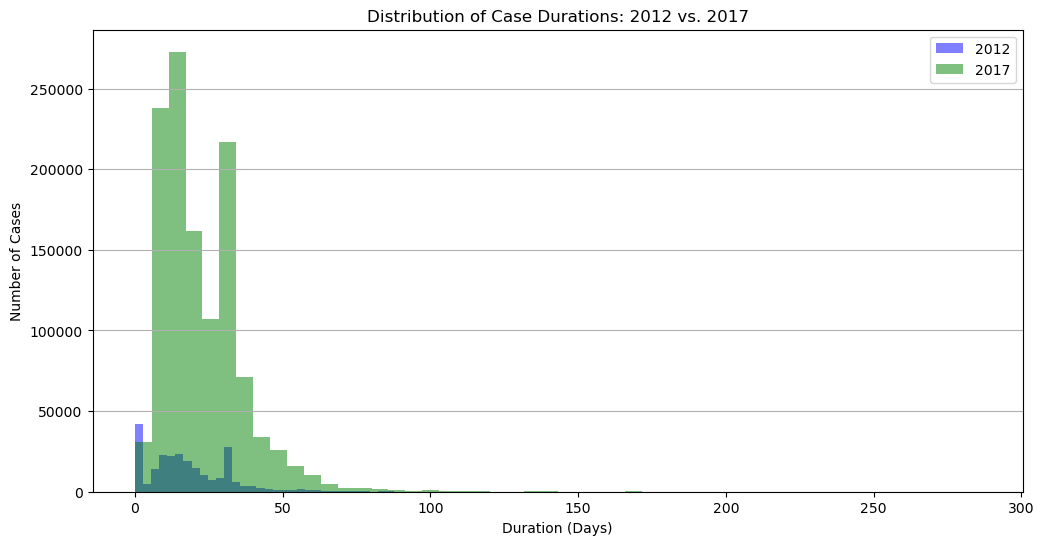

In [9]:
# Calculate case durations for 2012
df_2012['time:timestamp'] = pd.to_datetime(df_2012['time:timestamp'])
df_sorted_2012 = df_2012.sort_values(by=['case:concept:name', 'time:timestamp'])
df_sorted_2012['case_duration'] = df_sorted_2012.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.max() - x.min())
df_sorted_2012['case_duration_days'] = df_sorted_2012['case_duration'].dt.total_seconds() / (60 * 60 * 24)

# Calculate case durations for 2017
df_2017['time:timestamp'] = pd.to_datetime(df_2017['time:timestamp'])
df_sorted_2017 = df_2017.sort_values(by=['case:concept:name', 'time:timestamp'])
df_sorted_2017['case_duration'] = df_sorted_2017.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.max() - x.min())
df_sorted_2017['case_duration_days'] = df_sorted_2017['case_duration'].dt.total_seconds() / (60 * 60 * 24)

# Plotting
plt.figure(figsize=(12, 6))

# Plot histogram for 2012
plt.hist(df_sorted_2012['case_duration_days'], bins=50, alpha=0.5, label='2012', color='blue')

# Plot histogram for 2017
plt.hist(df_sorted_2017['case_duration_days'], bins=50, alpha=0.5, label='2017', color='green')

plt.title('Distribution of Case Durations: 2012 vs. 2017')
plt.xlabel('Duration (Days)')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(axis='y')
plt.show()


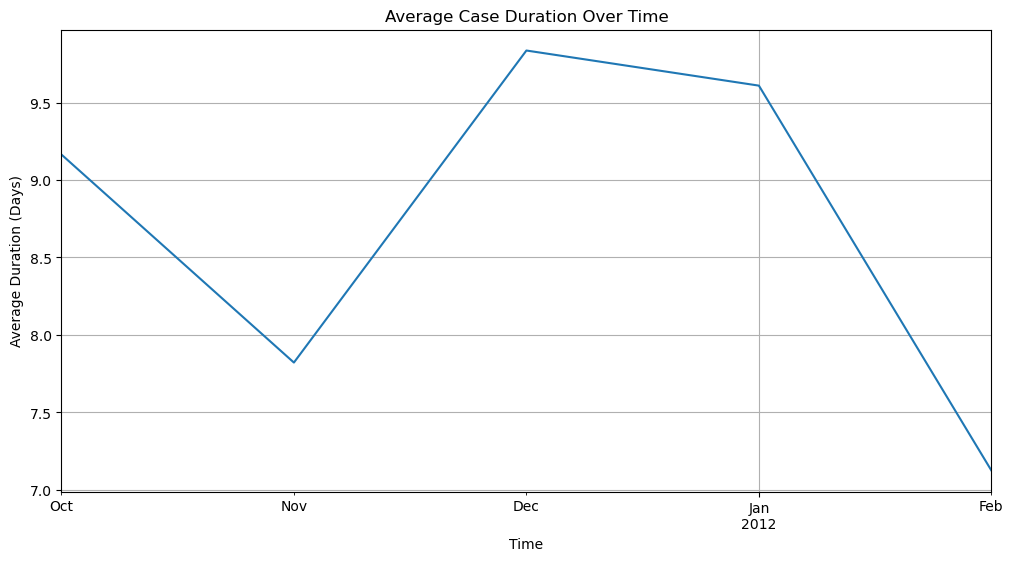

In [10]:
df_2012['time:timestamp'] = pd.to_datetime(df_2012['time:timestamp'])
df_sorted = df_2012.sort_values(by=['case:concept:name', 'time:timestamp'])

# Calculate case start and end times
case_start_end = df_sorted.groupby('case:concept:name')['time:timestamp'].agg([min, max])

# Calculate case durations in days
case_start_end['duration'] = (case_start_end['max'] - case_start_end['min']).dt.total_seconds() / (60 * 60 * 24)

# Resample to get average case duration by month
monthly_avg_duration = case_start_end.resample('M', on='min')['duration'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_avg_duration.plot()
plt.title('Average Case Duration Over Time 2012')
plt.xlabel('Time')
plt.ylabel('Average Duration (Days)')
plt.grid(True)
plt.show()

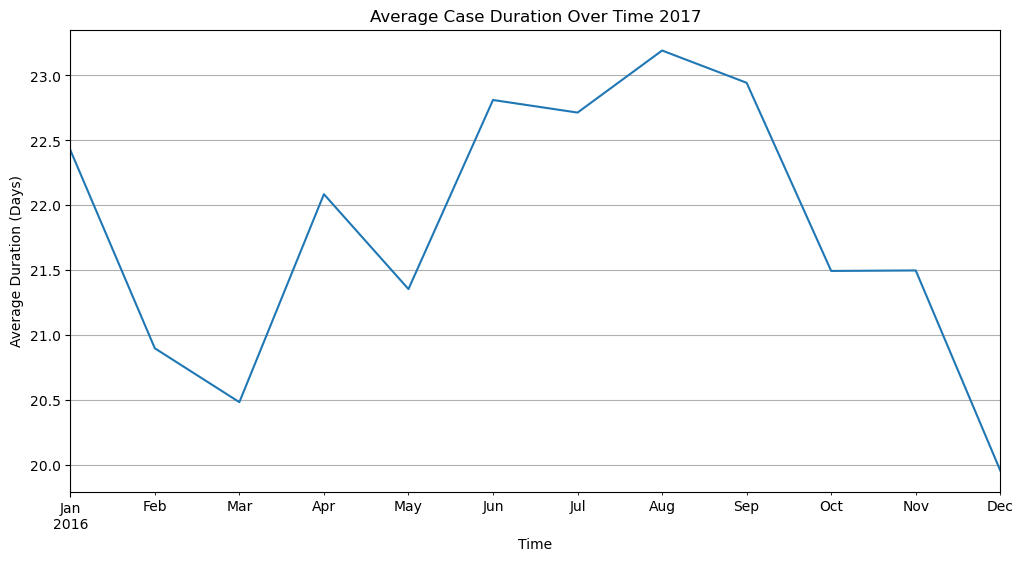

In [11]:
df_2017['time:timestamp'] = pd.to_datetime(df_2017['time:timestamp'])
df_sorted = df_2017.sort_values(by=['case:concept:name', 'time:timestamp'])

# Calculate case start and end times
case_start_end = df_sorted.groupby('case:concept:name')['time:timestamp'].agg([min, max])

# Calculate case durations in days
case_start_end['duration'] = (case_start_end['max'] - case_start_end['min']).dt.total_seconds() / (60 * 60 * 24)

# Resample to get average case duration by month
monthly_avg_duration = case_start_end.resample('M', on='min')['duration'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_avg_duration.plot()
plt.title('Average Case Duration Over Time 2017')
plt.xlabel('Time')
plt.ylabel('Average Duration (Days)')
plt.grid(True)
plt.show()

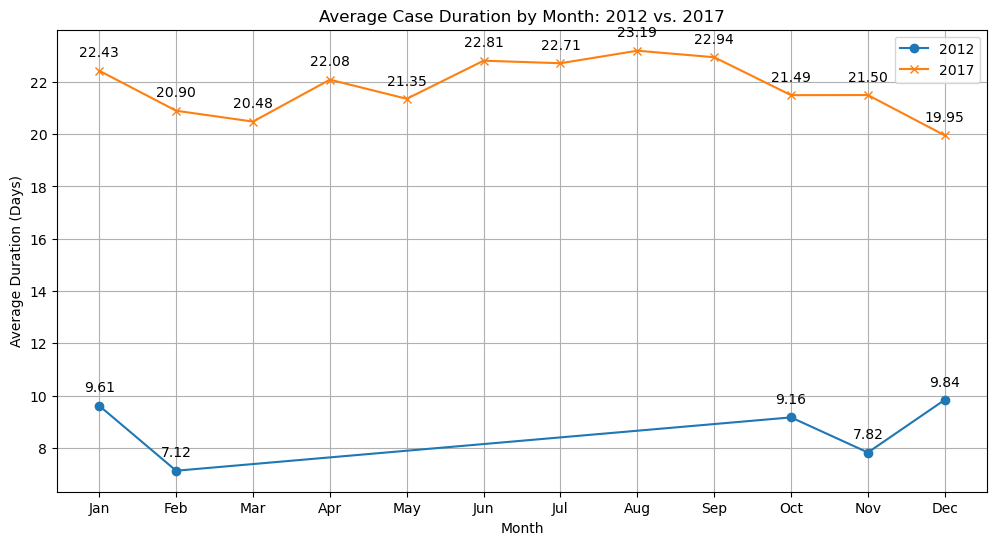

In [16]:
# Function to calculate monthly average duration
def calculate_monthly_avg_duration(df):
    df_sorted = df.sort_values(by=['case:concept:name', 'time:timestamp'])
    case_start_end = df_sorted.groupby('case:concept:name')['time:timestamp'].agg([min, max])
    case_start_end['duration'] = (case_start_end['max'] - case_start_end['min']).dt.total_seconds() / (60 * 60 * 24)
    case_start_end['month'] = case_start_end['min'].dt.month  # Extract month from start time
    monthly_avg_duration = case_start_end.groupby('month')['duration'].mean()
    return monthly_avg_duration

# Calculate monthly average duration for both years
monthly_avg_duration_2012 = calculate_monthly_avg_duration(df_2012)
monthly_avg_duration_2017 = calculate_monthly_avg_duration(df_2017)

# Plotting
plt.figure(figsize=(12, 6))
line_2012, = plt.plot(monthly_avg_duration_2012.index, monthly_avg_duration_2012.values, label='2012', marker='o')
line_2017, = plt.plot(monthly_avg_duration_2017.index, monthly_avg_duration_2017.values, label='2017', marker='x')

# Annotating each point on the 2012 line
for i, txt in enumerate(monthly_avg_duration_2012.values):
    plt.annotate(f'{txt:.2f}', (monthly_avg_duration_2012.index[i], monthly_avg_duration_2012.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Annotating each point on the 2017 line
for i, txt in enumerate(monthly_avg_duration_2017.values):
    plt.annotate(f'{txt:.2f}', (monthly_avg_duration_2017.index[i], monthly_avg_duration_2017.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Average Case Duration by Month: 2012 vs. 2017')
plt.xlabel('Month')
plt.ylabel('Average Duration (Days)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(handles=[line_2012, line_2017])
plt.grid(True)
plt.show()


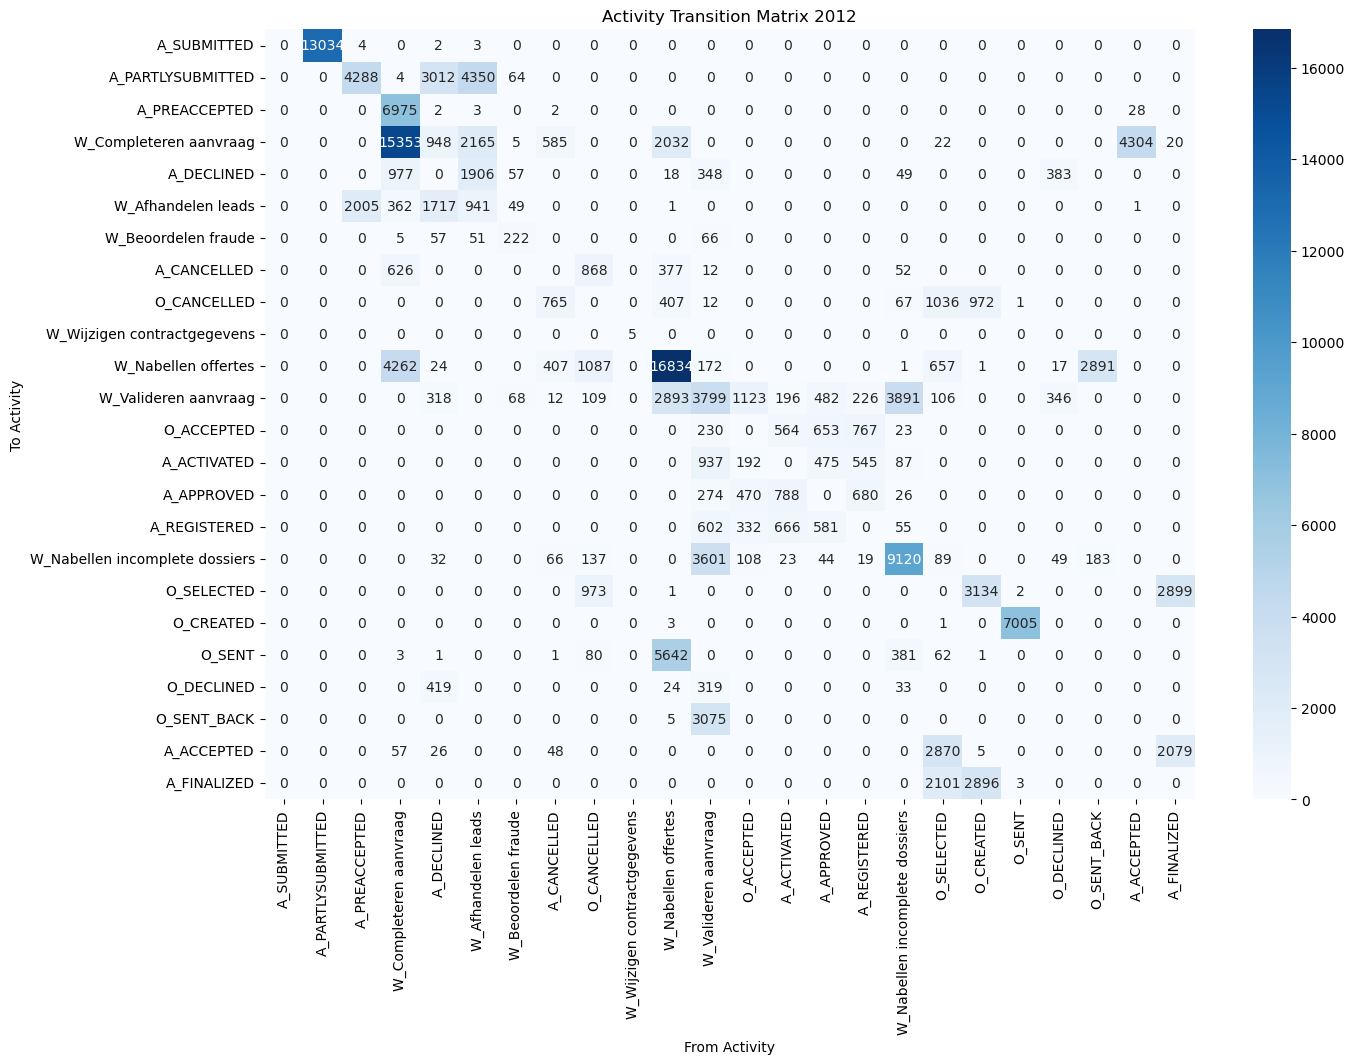

In [19]:
# Initialize the transitions DataFrame with zeros
unique_activities = df_2012['concept:name'].unique()
transitions = pd.DataFrame(0, index=unique_activities, columns=unique_activities)

# Populate the transitions DataFrame with counts
for i in range(1, len(df_2012)):
    current_activity = df_2012.iloc[i]['concept:name']
    previous_activity = df_2012.iloc[i-1]['concept:name']
    
    # Check if the previous and current activities are within the same case
    if df_2012.iloc[i]['case:concept:name'] == df_2012.iloc[i-1]['case:concept:name']:
        transitions.at[previous_activity, current_activity] += 1

# Plotting
plt.figure(figsize=(15, 10))
sns.heatmap(transitions, annot=True, fmt='d', cmap='Blues')
plt.title('Activity Transition Matrix 2012')
plt.xlabel('From Activity')
plt.ylabel('To Activity')
plt.show()

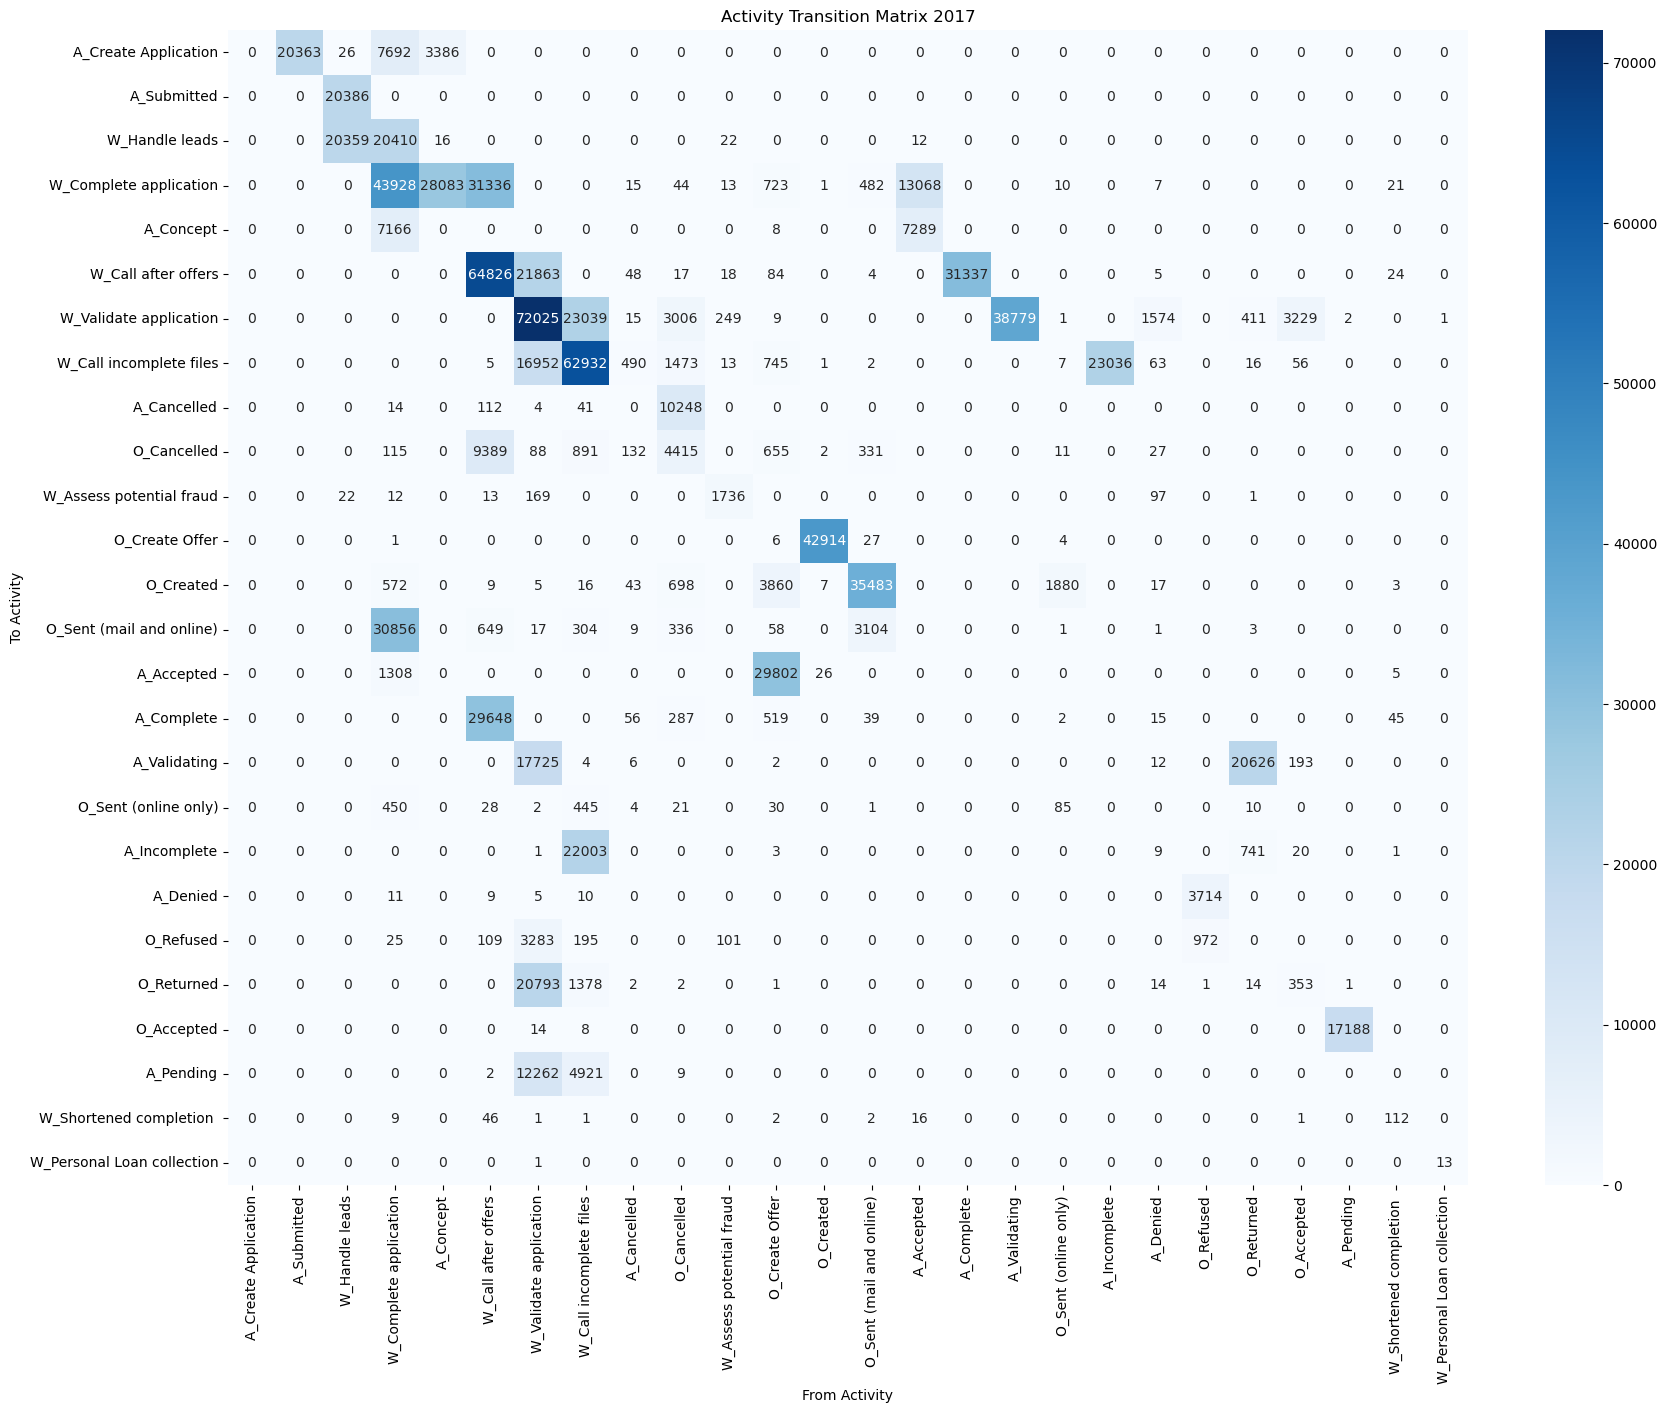

In [21]:
# Initialize the transitions DataFrame with zeros
unique_activities = df_2017['concept:name'].unique()
transitions = pd.DataFrame(0, index=unique_activities, columns=unique_activities)

# Populate the transitions DataFrame with counts
for i in range(1, len(df_2017)):
    current_activity = df_2017.iloc[i]['concept:name']
    previous_activity = df_2017.iloc[i-1]['concept:name']
    
    # Check if the previous and current activities are within the same case
    if df_2017.iloc[i]['case:concept:name'] == df_2017.iloc[i-1]['case:concept:name']:
        transitions.at[previous_activity, current_activity] += 1

# Plotting
plt.figure(figsize=(20, 15))
sns.heatmap(transitions, annot=True, fmt='d', cmap='Blues')
plt.title('Activity Transition Matrix 2017')
plt.xlabel('From Activity')
plt.ylabel('To Activity')
plt.show()